# 04 — Gene Essentiality, Fitness, and Multi-Omics

Integrated view of ADP1 gene properties: essentiality (TnSeq + FBA), mutant
growth fitness across carbon sources, proteomics across strains, and pangenome
conservation. Inspired by the BERDL Genome Dashboard.

**Key questions:**
1. How do TnSeq essentiality and FBA predictions agree?
2. Which carbon sources reveal the most fitness variation?
3. How does protein abundance correlate across engineered strains?
4. Are essential genes more conserved (core) in the pangenome?

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 150

conn = sqlite3.connect(Path('../user_data/berdl_tables.db'))
gf = pd.read_sql('SELECT * FROM genome_features', conn)

# Clean up columns
prot_cols = [c for c in gf.columns if c.startswith('proteomics_avg_')]
growth_cols = [c for c in gf.columns if c.startswith('mutant_growth_')]
strain_names = [c.replace('proteomics_avg_', '') for c in prot_cols]
condition_names = [c.replace('mutant_growth_', '') for c in growth_cols]

print(f'Genes: {len(gf):,}')
print(f'Proteomics strains: {len(prot_cols)} ({gf[prot_cols[0]].notna().sum()} genes with data)')
print(f'Growth conditions: {len(growth_cols)} ({gf[growth_cols[0]].notna().sum()} genes with data)')

Genes: 5,852
Proteomics strains: 7 (2383 genes with data)
Growth conditions: 8 (2279 genes with data)


## 1. Essentiality Overview

Compare TnSeq essentiality calls on minimal vs LB media, and cross-tabulate
with FBA predictions.

Genes with essentiality data: 3405


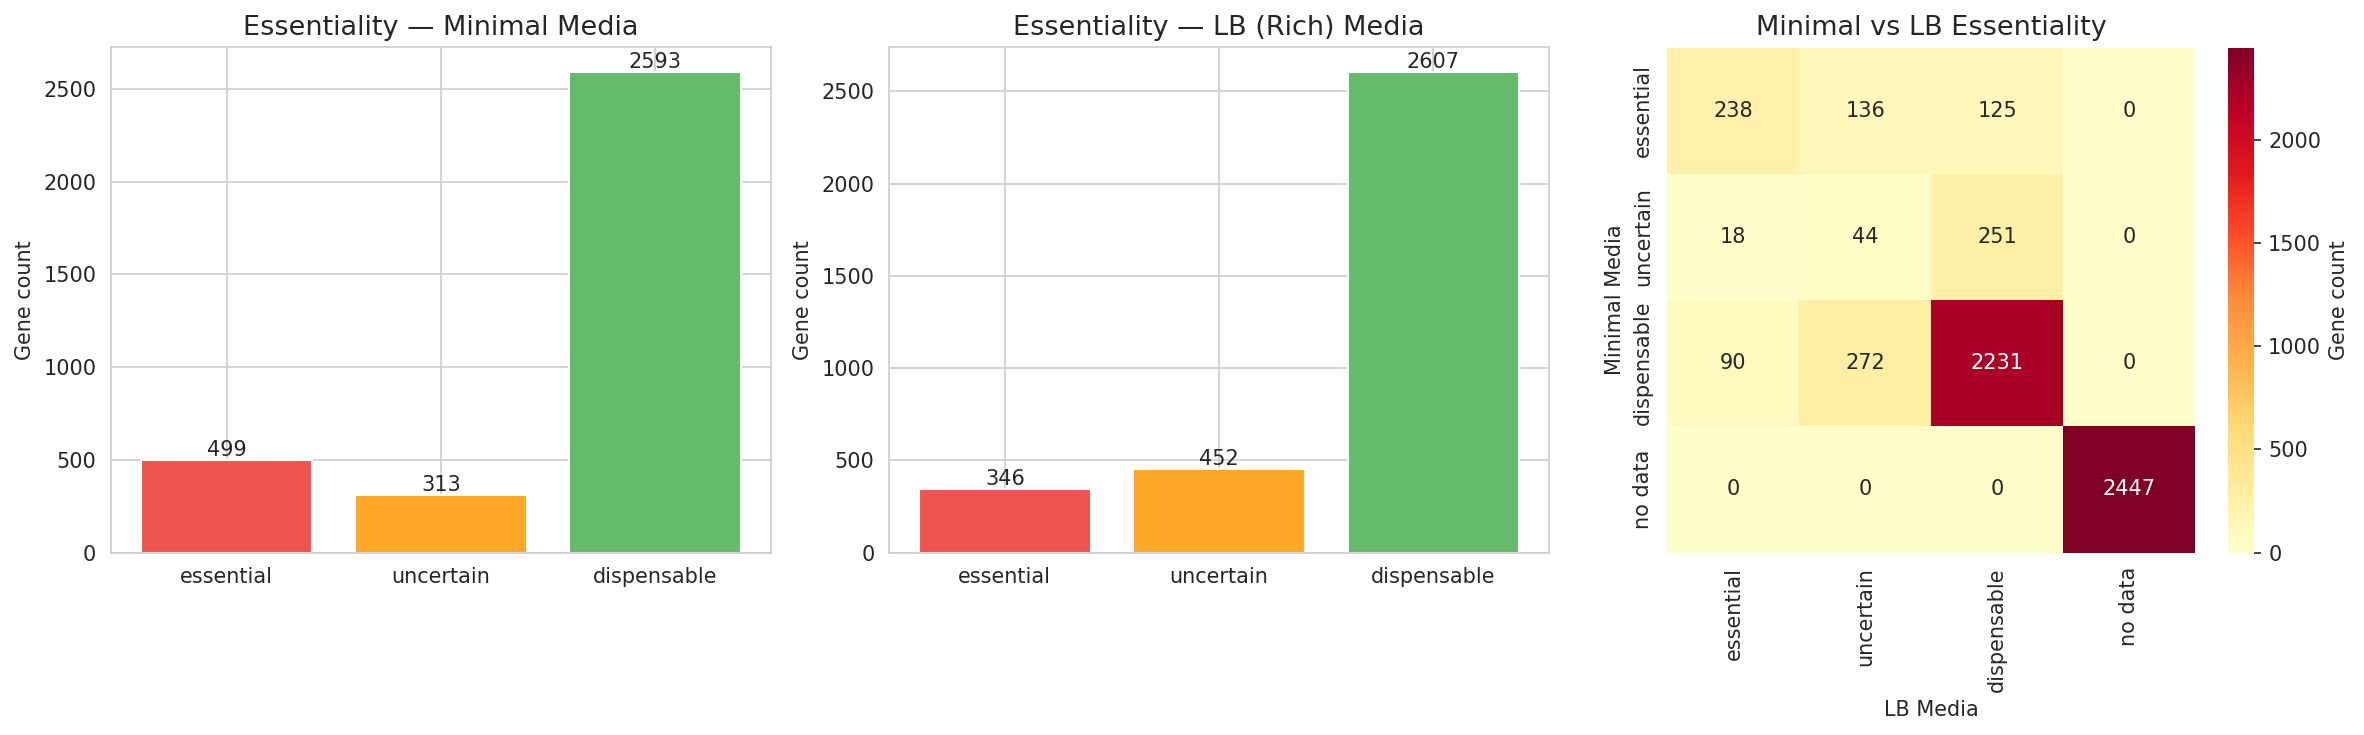

In [2]:
# TnSeq essentiality: minimal vs LB
ess_data = gf[gf['essentiality_minimal'].notna()].copy()
print(f'Genes with essentiality data: {len(ess_data)}')

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Minimal media essentiality
order = ['essential', 'uncertain', 'dispensable']
colors = {'essential': '#EF5350', 'uncertain': '#FFA726', 'dispensable': '#66BB6A'}
for ax, col, title in [(axes[0], 'essentiality_minimal', 'Minimal Media'),
                        (axes[1], 'essentiality_lb', 'LB (Rich) Media')]:
    counts = gf[col].value_counts()
    counts = counts.reindex(order, fill_value=0)
    bars = ax.bar(counts.index, counts.values, color=[colors[x] for x in counts.index])
    ax.set_title(f'Essentiality — {title}', fontsize=13)
    ax.set_ylabel('Gene count')
    for bar, val in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                str(val), ha='center', fontsize=10)

# Panel 3: Cross-tabulation
ct = pd.crosstab(gf['essentiality_minimal'], gf['essentiality_lb'],
                  margins=False, dropna=False)
ct = ct.reindex(index=order + [np.nan], columns=order + [np.nan], fill_value=0)
ct.index = [str(x) if pd.notna(x) else 'no data' for x in ct.index]
ct.columns = [str(x) if pd.notna(x) else 'no data' for x in ct.columns]
sns.heatmap(ct, annot=True, fmt='d', cmap='YlOrRd', ax=axes[2],
            cbar_kws={'label': 'Gene count'})
axes[2].set_title('Minimal vs LB Essentiality', fontsize=13)
axes[2].set_xlabel('LB Media')
axes[2].set_ylabel('Minimal Media')

plt.tight_layout()
plt.savefig('../figures/essentiality_overview.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. FBA vs TnSeq Concordance

How well do FBA flux-based essentiality predictions match TnSeq essentiality calls?

Genes with both FBA and TnSeq data: 866

Concordance matrix:


fba_essential,FBA Essential,FBA Non-essential
tnseq_essential,,
TnSeq Essential,121,78
TnSeq Non-essential,149,518



Concordance: 639/866 (73.8%)


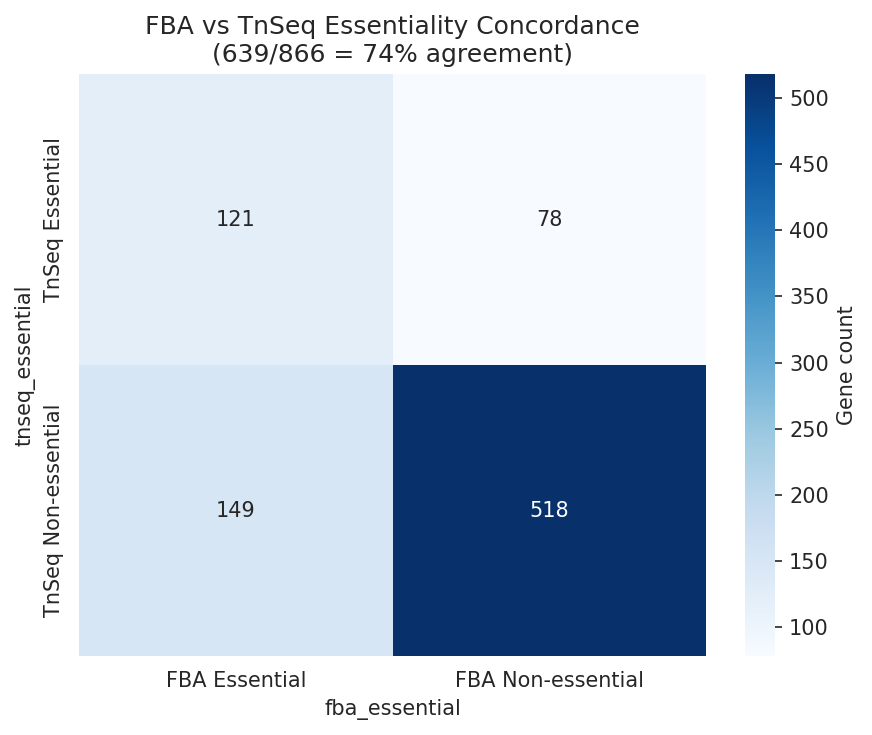

In [3]:
# Define FBA essentiality: essential if rich_media_class == 'essential'
concordance = gf[gf['essentiality_lb'].notna() & gf['rich_media_class'].notna()].copy()
concordance['fba_essential'] = concordance['rich_media_class'] == 'essential'
concordance['tnseq_essential'] = concordance['essentiality_lb'] == 'essential'

print(f'Genes with both FBA and TnSeq data: {len(concordance)}')

# Concordance matrix
ct = pd.crosstab(concordance['tnseq_essential'].map({True: 'TnSeq Essential', False: 'TnSeq Non-essential'}),
                  concordance['fba_essential'].map({True: 'FBA Essential', False: 'FBA Non-essential'}))
print('\nConcordance matrix:')
display(ct)

# Concordance rate
agree = ((concordance['fba_essential'] == True) & (concordance['tnseq_essential'] == True)).sum() + \
        ((concordance['fba_essential'] == False) & (concordance['tnseq_essential'] == False)).sum()
print(f'\nConcordance: {agree}/{len(concordance)} ({agree/len(concordance)*100:.1f}%)')

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', ax=ax,
            cbar_kws={'label': 'Gene count'})
ax.set_title(f'FBA vs TnSeq Essentiality Concordance\n({agree}/{len(concordance)} = {agree/len(concordance)*100:.0f}% agreement)')
plt.tight_layout()
plt.savefig('../figures/fba_tnseq_concordance.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Mutant Growth Fitness by Carbon Source

Boxplot of mutant growth fitness across 8 carbon sources. Negative values
indicate growth defects; values near zero indicate wild-type growth.

/tmp/ipykernel_1873/905659573.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=growth_melt, x='Carbon Source', y='Fitness', ax=axes[0],


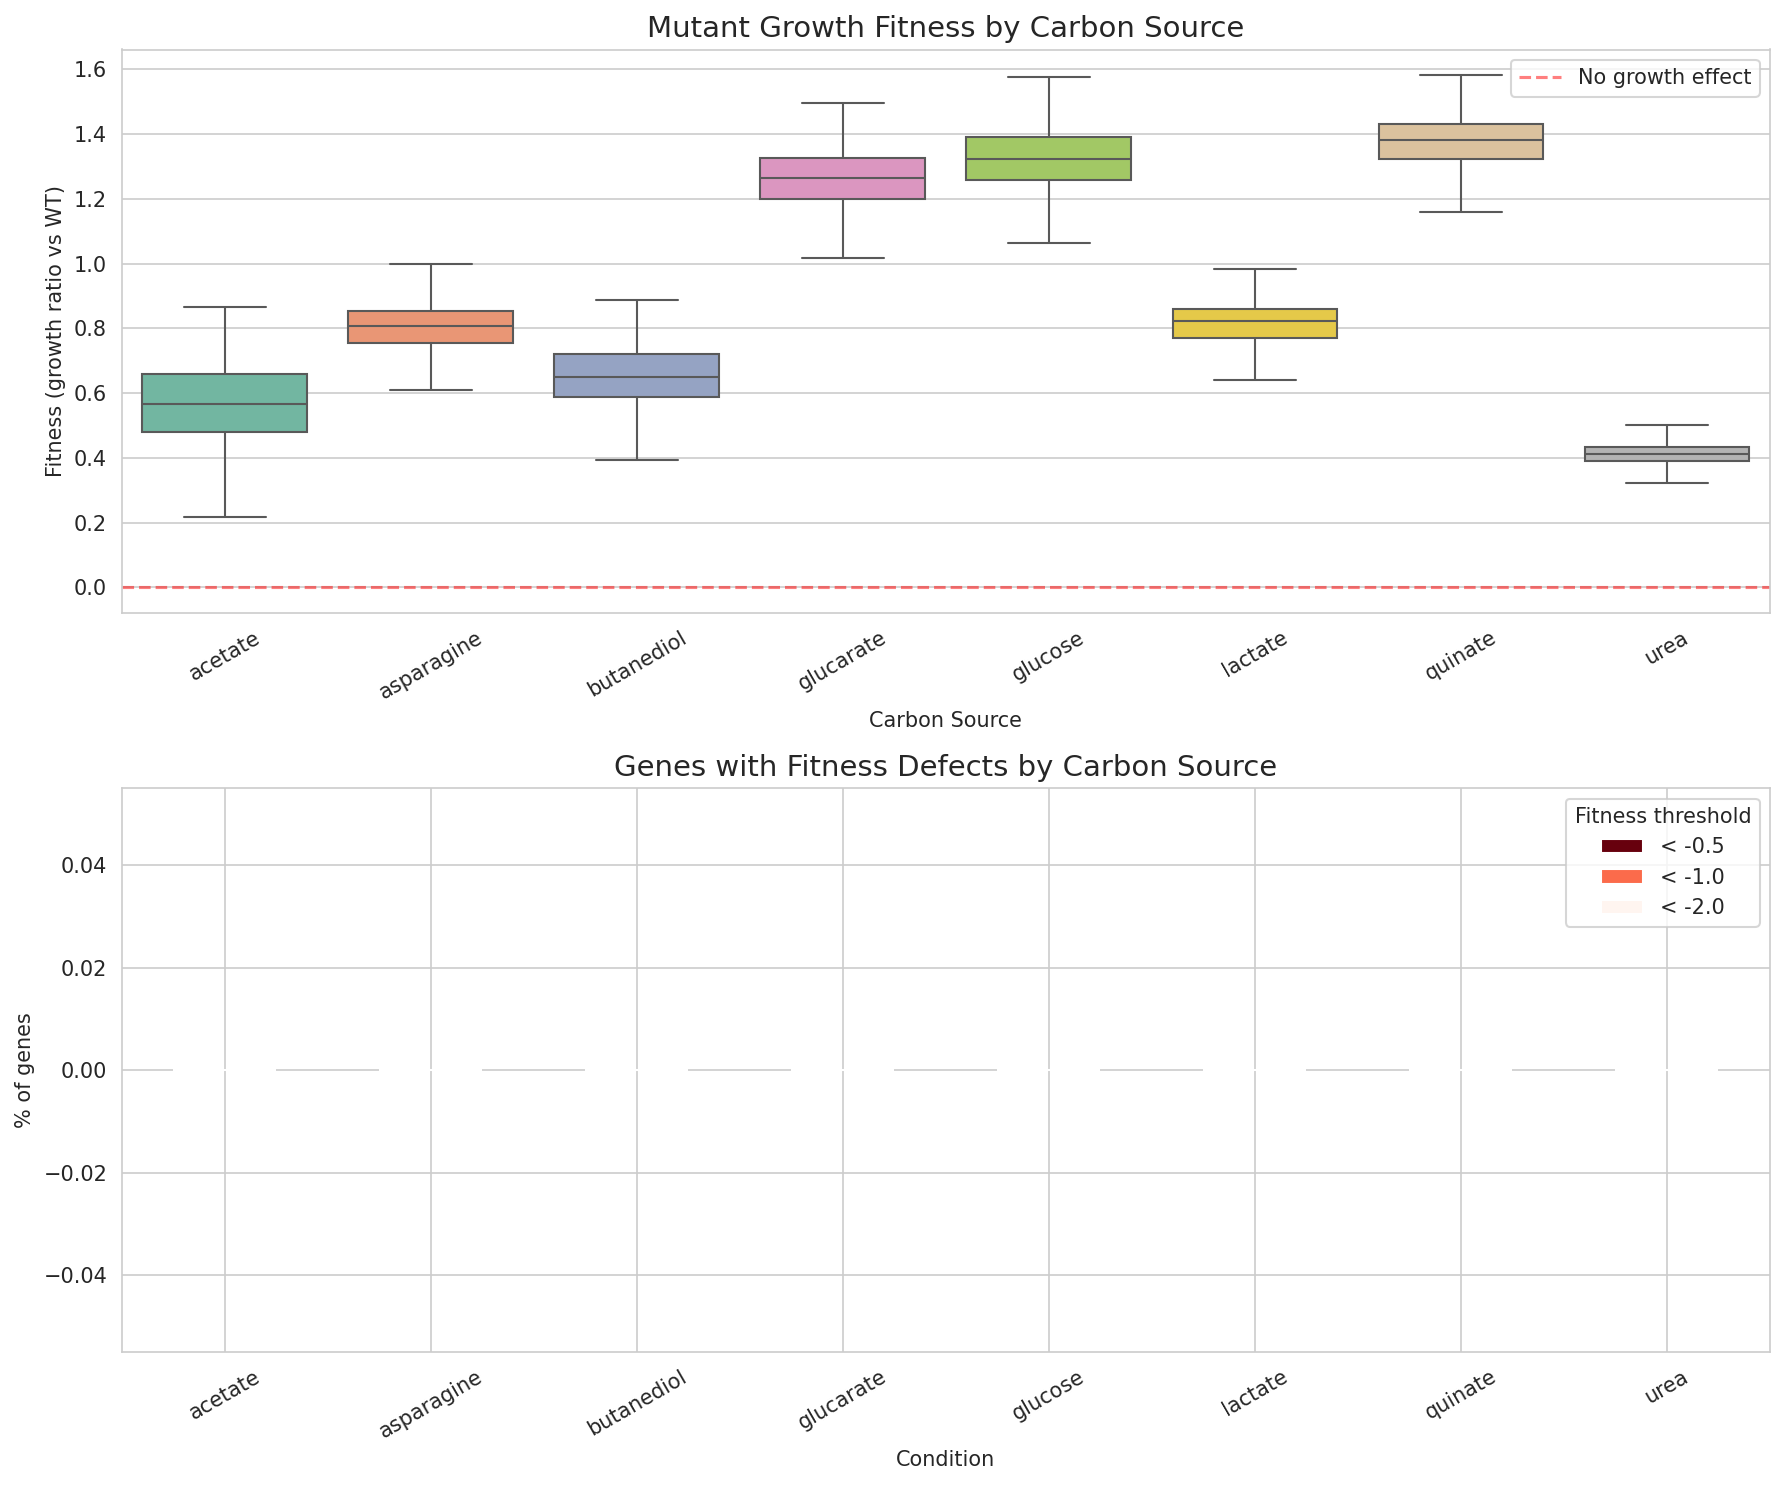

In [4]:
# Reshape growth data for plotting
growth_data = gf[growth_cols].copy()
growth_data.columns = condition_names
growth_melt = growth_data.melt(var_name='Carbon Source', value_name='Fitness')
growth_melt = growth_melt.dropna()

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Panel 1: Boxplot
sns.boxplot(data=growth_melt, x='Carbon Source', y='Fitness', ax=axes[0],
            palette='Set2', showfliers=False)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No growth effect')
axes[0].set_title('Mutant Growth Fitness by Carbon Source', fontsize=14)
axes[0].set_ylabel('Fitness (growth ratio vs WT)')
axes[0].tick_params(axis='x', rotation=30)
axes[0].legend()

# Panel 2: Fraction of genes with strong fitness defects per condition
thresholds = [-0.5, -1.0, -2.0]
defect_data = []
for cond in condition_names:
    col = f'mutant_growth_{cond}'
    vals = gf[col].dropna()
    for thresh in thresholds:
        frac = (vals < thresh).sum() / len(vals) * 100
        defect_data.append({'Condition': cond, 'Threshold': f'< {thresh}', 'Fraction (%)': frac})

defect_df = pd.DataFrame(defect_data)
defect_pivot = defect_df.pivot(index='Condition', columns='Threshold', values='Fraction (%)')
defect_pivot.plot(kind='bar', ax=axes[1], colormap='Reds_r')
axes[1].set_title('Genes with Fitness Defects by Carbon Source', fontsize=14)
axes[1].set_ylabel('% of genes')
axes[1].tick_params(axis='x', rotation=30)
axes[1].legend(title='Fitness threshold')

plt.tight_layout()
plt.savefig('../figures/mutant_growth_fitness.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Mutant Growth Condition Correlation

How correlated are fitness effects across different carbon sources?

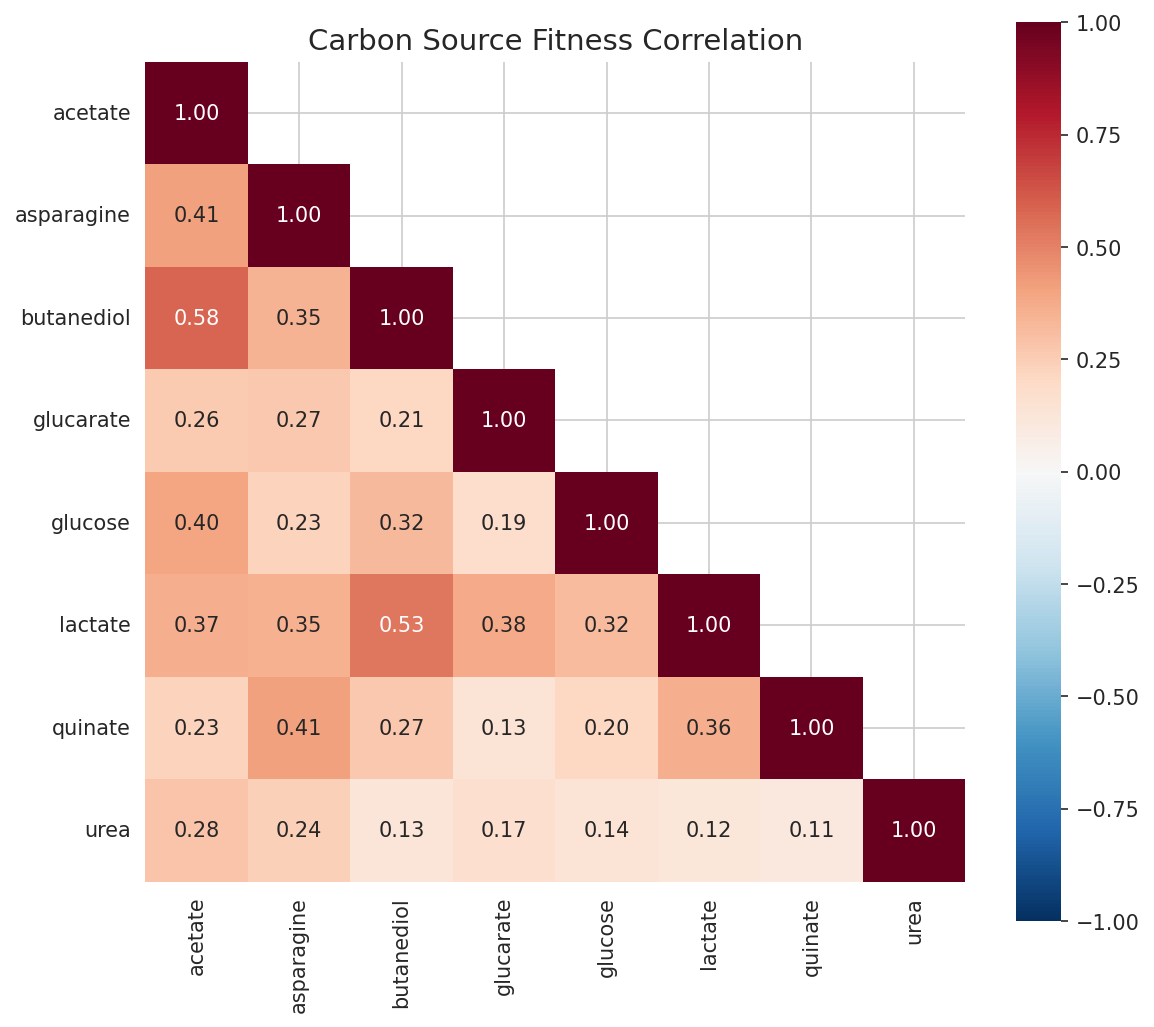

Mean pairwise correlation: 0.443
Min: 0.109 (('urea', 'quinate'))
Max: 1.000 (('acetate', 'acetate'))


In [5]:
# Correlation matrix of growth fitness across conditions
growth_matrix = gf[growth_cols].copy()
growth_matrix.columns = condition_names
corr = growth_matrix.corr()

fig, ax = plt.subplots(figsize=(8, 7))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, mask=mask, ax=ax, square=True)
ax.set_title('Carbon Source Fitness Correlation', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/growth_condition_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
upper = corr.where(~mask).stack()
print(f'Mean pairwise correlation: {upper.mean():.3f}')
print(f'Min: {upper.min():.3f} ({upper.idxmin()})')
print(f'Max: {upper.max():.3f} ({upper.idxmax()})')

## 5. Proteomics: Cross-Strain Protein Abundance

Protein abundance measured across 7 ADP1 strains (WT + 6 engineered).

Genes with proteomics data: 2383


/tmp/ipykernel_1873/678128188.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=prot_melt, x='Strain', y='Abundance', ax=axes[0],


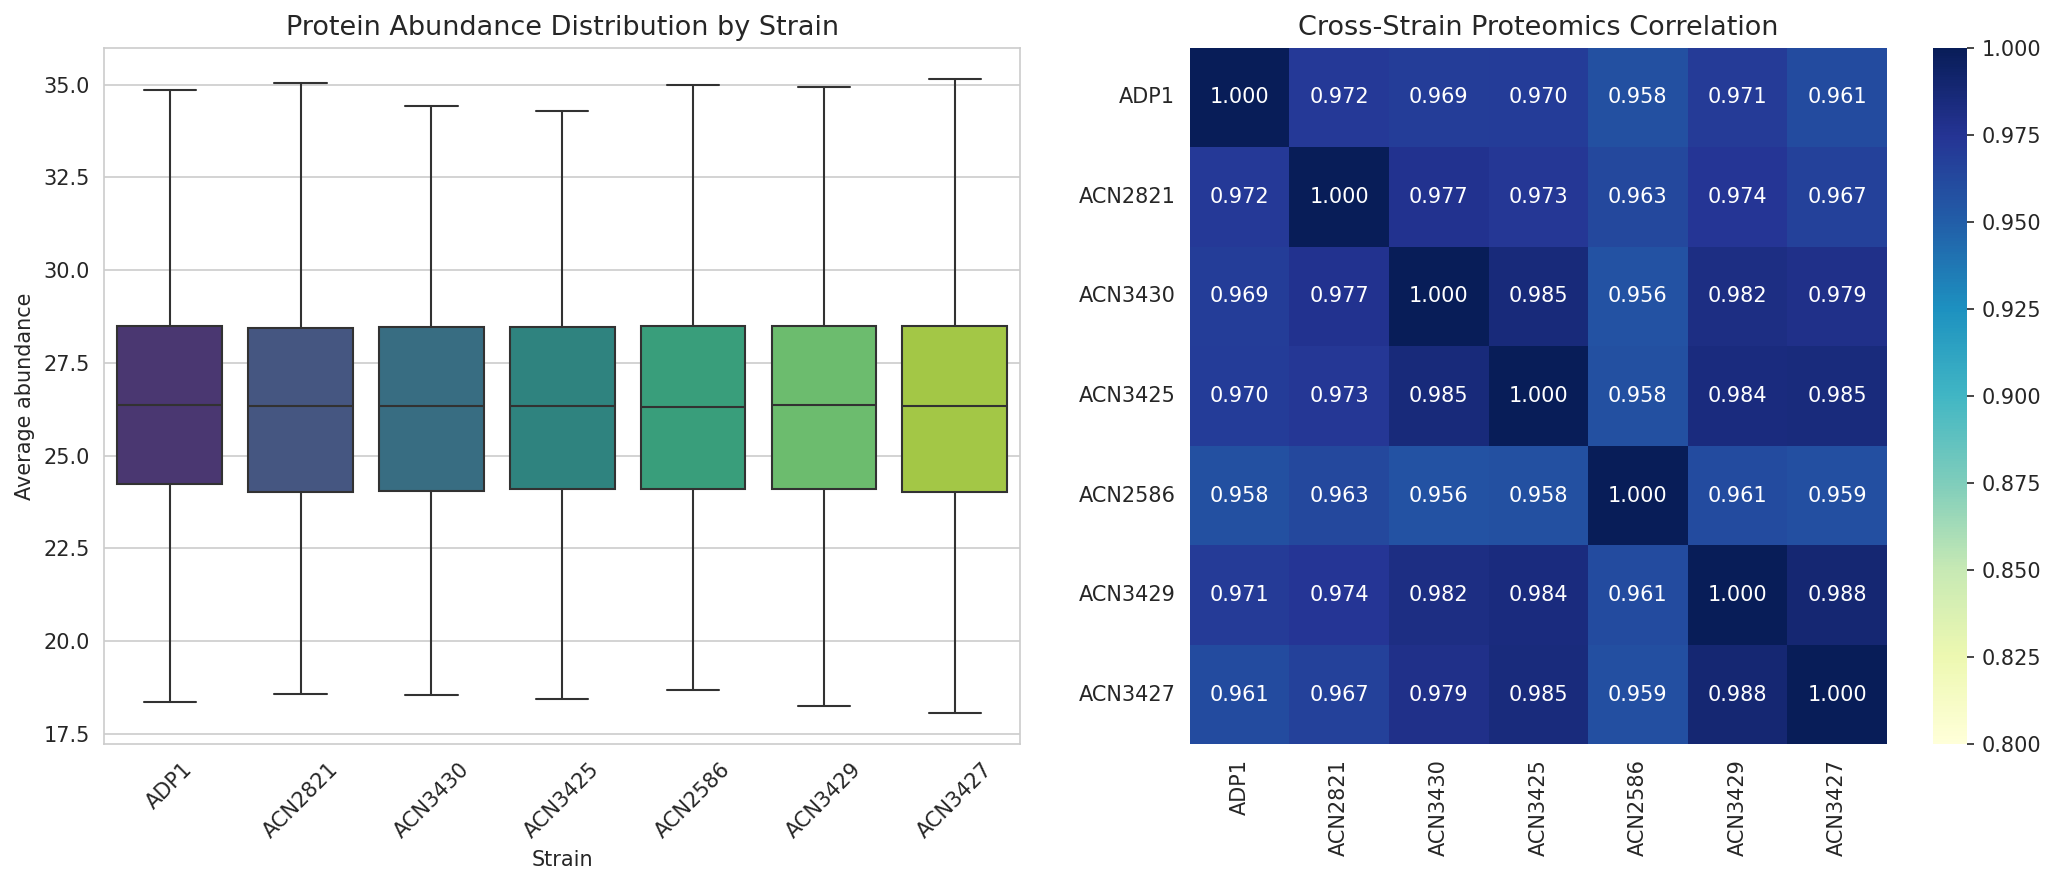

In [6]:
# Proteomics data
prot_data = gf[gf[prot_cols[0]].notna()][prot_cols].copy()
prot_data.columns = strain_names
print(f'Genes with proteomics data: {len(prot_data)}')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Distribution of protein abundance per strain
prot_melt = prot_data.melt(var_name='Strain', value_name='Abundance')
sns.boxplot(data=prot_melt, x='Strain', y='Abundance', ax=axes[0],
            palette='viridis', showfliers=False)
axes[0].set_title('Protein Abundance Distribution by Strain', fontsize=13)
axes[0].set_ylabel('Average abundance')
axes[0].tick_params(axis='x', rotation=45)

# Panel 2: Strain correlation heatmap
prot_corr = prot_data.corr()
sns.heatmap(prot_corr, annot=True, fmt='.3f', cmap='YlGnBu',
            ax=axes[1], square=True, vmin=0.8, vmax=1.0)
axes[1].set_title('Cross-Strain Proteomics Correlation', fontsize=13)

plt.tight_layout()
plt.savefig('../figures/proteomics_cross_strain.png', dpi=150, bbox_inches='tight')
plt.show()

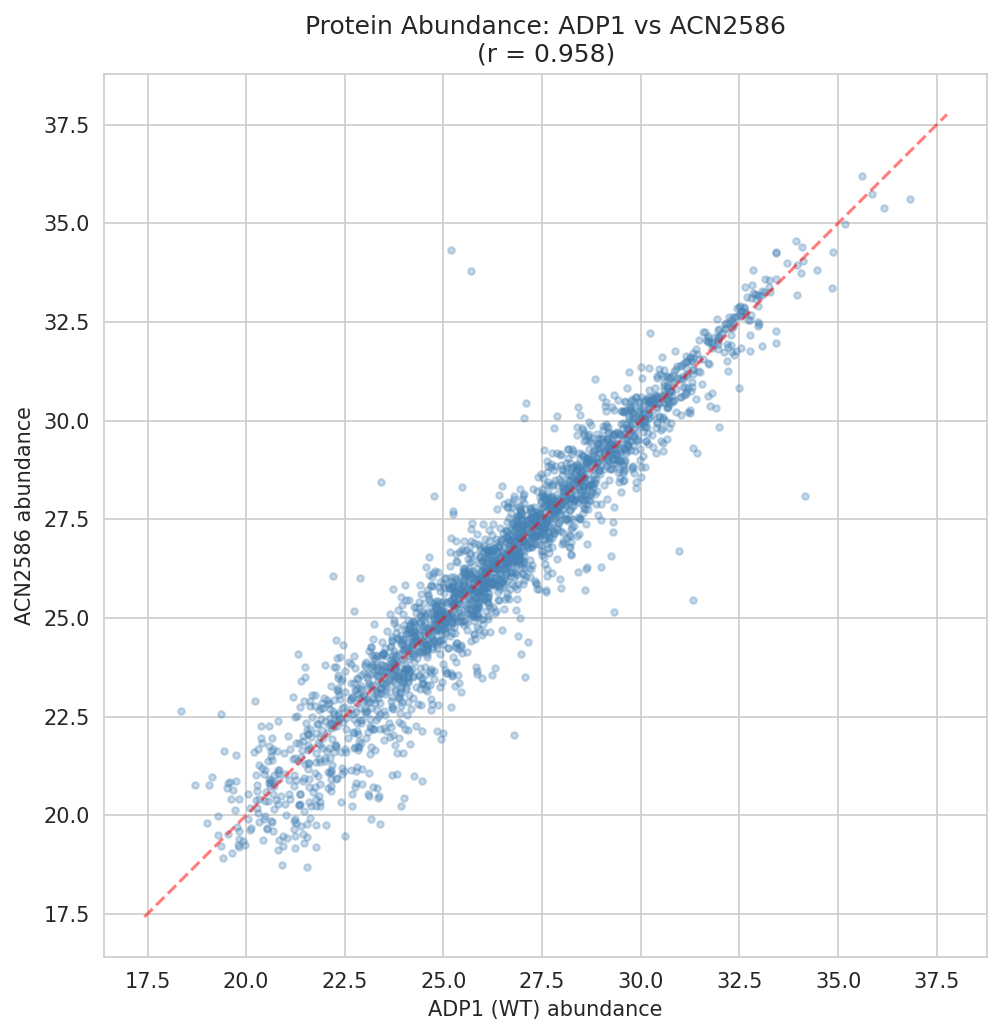

In [7]:
# Scatter: WT (ADP1) vs most different engineered strain
# Find which strain differs most from ADP1
adp1_corr = prot_corr['ADP1'].drop('ADP1')
least_corr_strain = adp1_corr.idxmin()

fig, ax = plt.subplots(figsize=(7, 7))
plot_data = prot_data[['ADP1', least_corr_strain]].dropna()
ax.scatter(plot_data['ADP1'], plot_data[least_corr_strain],
           alpha=0.3, s=10, c='steelblue')
# Add diagonal
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'r--', alpha=0.5)
ax.set_xlabel(f'ADP1 (WT) abundance')
ax.set_ylabel(f'{least_corr_strain} abundance')
ax.set_title(f'Protein Abundance: ADP1 vs {least_corr_strain}\n(r = {adp1_corr[least_corr_strain]:.3f})')
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('../figures/proteomics_wt_vs_engineered.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Essentiality vs Pangenome Conservation

Are essential genes more likely to be in the core pangenome?

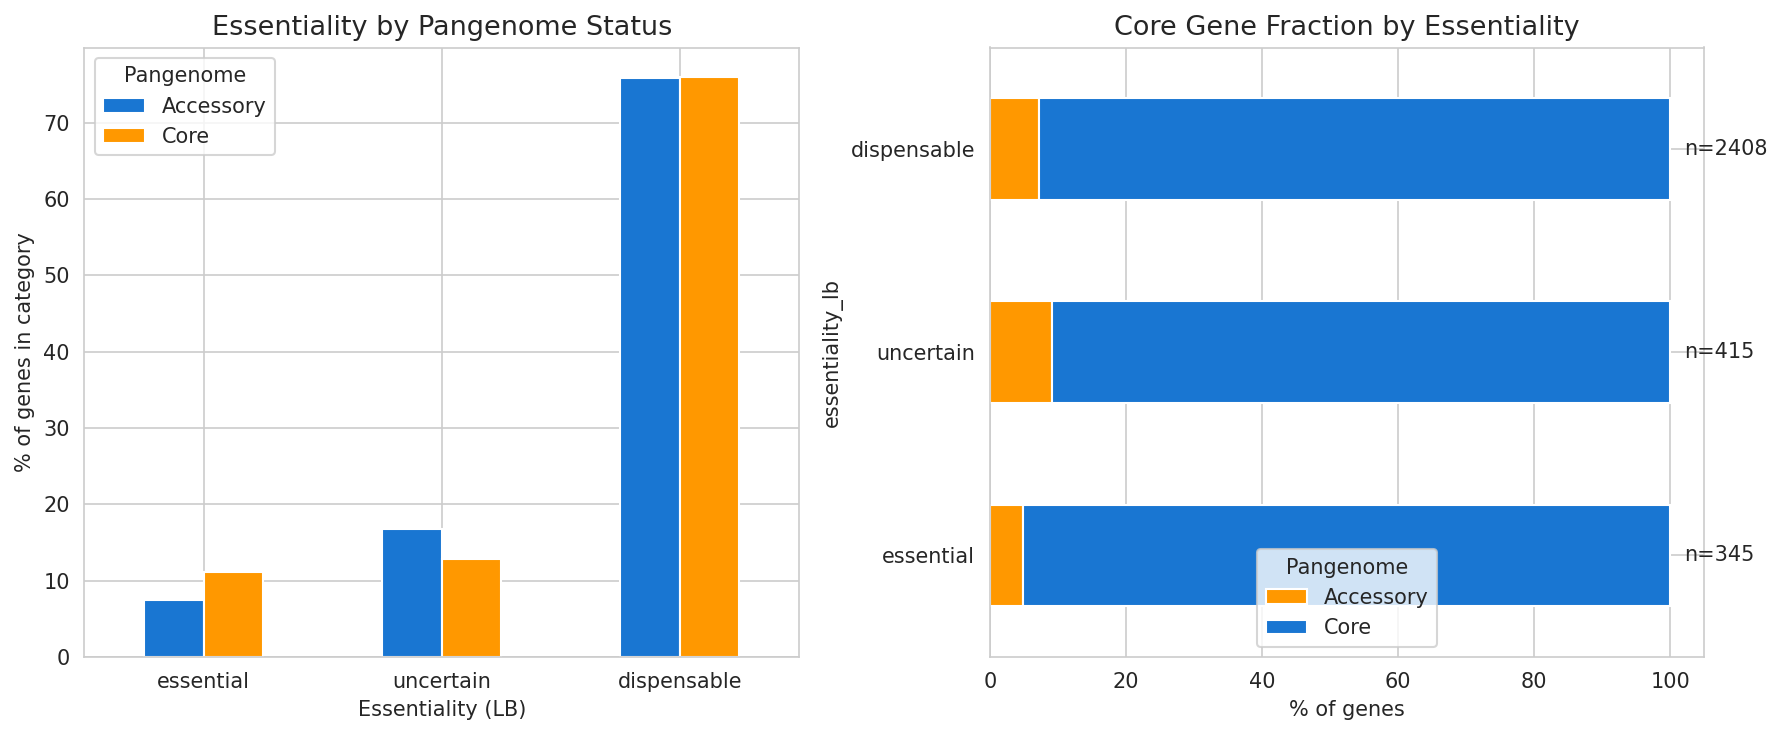

In [8]:
# Essentiality vs core/accessory
ess_pan = gf[gf['essentiality_lb'].notna() & gf['pangenome_is_core'].notna()].copy()
ess_pan['core'] = ess_pan['pangenome_is_core'].map({1: 'Core', 0: 'Accessory'})

ct = pd.crosstab(ess_pan['essentiality_lb'], ess_pan['core'], normalize='columns') * 100
ct = ct.reindex(['essential', 'uncertain', 'dispensable'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ct.plot(kind='bar', ax=axes[0], color=['#1976D2', '#FF9800'])
axes[0].set_title('Essentiality by Pangenome Status', fontsize=13)
axes[0].set_ylabel('% of genes in category')
axes[0].set_xlabel('Essentiality (LB)')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Pangenome')

# Panel 2: Stacked bar showing core fraction per essentiality class
ct2 = pd.crosstab(ess_pan['essentiality_lb'], ess_pan['core'])
ct2 = ct2.reindex(['essential', 'uncertain', 'dispensable'])
ct2_norm = ct2.div(ct2.sum(axis=1), axis=0) * 100
ct2_norm.plot(kind='barh', stacked=True, ax=axes[1],
               color=['#FF9800', '#1976D2'])
axes[1].set_title('Core Gene Fraction by Essentiality', fontsize=13)
axes[1].set_xlabel('% of genes')
axes[1].legend(title='Pangenome')
for i, (idx, row) in enumerate(ct2.iterrows()):
    total = row.sum()
    axes[1].text(102, i, f'n={total}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/essentiality_vs_pangenome.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. FBA Flux Classes: Rich vs Minimal Media

Heatmap of how genes shift between flux classes across media conditions.

Genes with both FBA flux classes: 866


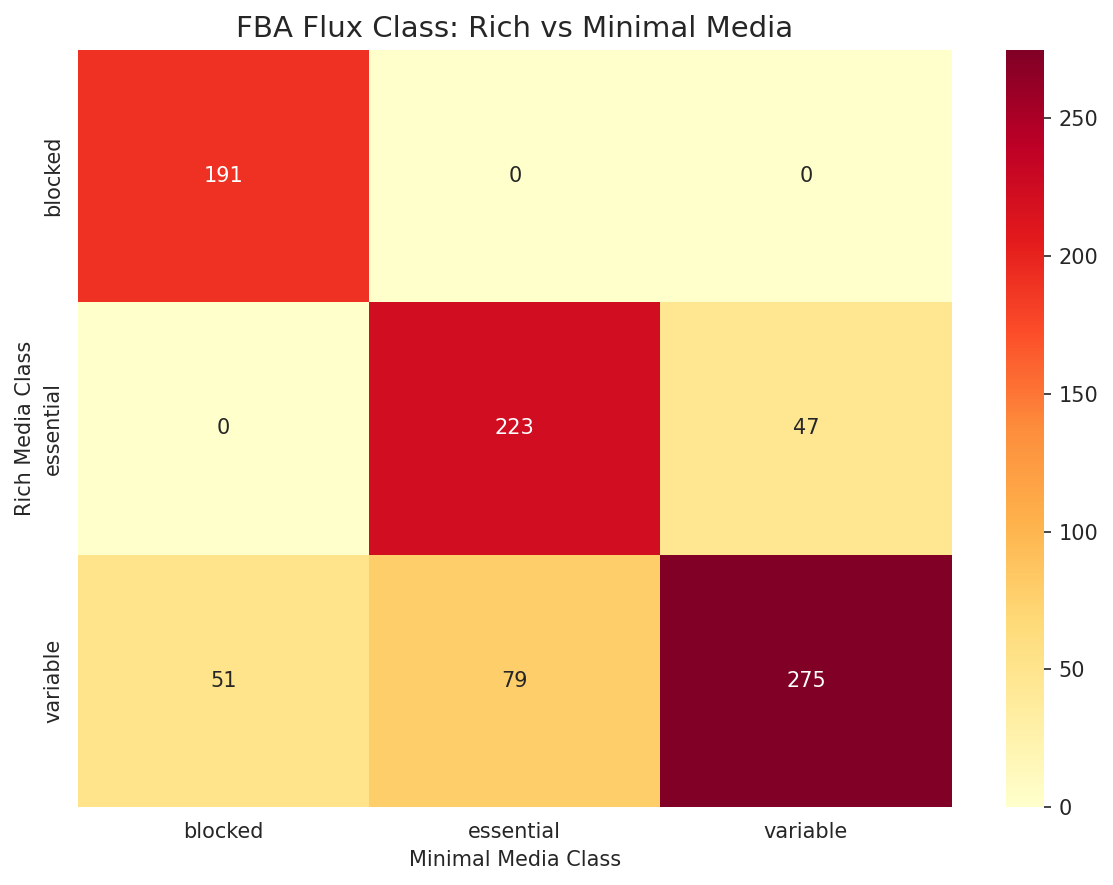


Genes that change flux class between media: 177/866 (20%)


In [9]:
# FBA flux class transition between rich and minimal media
flux_data = gf[gf['rich_media_class'].notna() & gf['minimal_media_class'].notna()].copy()
print(f'Genes with both FBA flux classes: {len(flux_data)}')

ct = pd.crosstab(flux_data['rich_media_class'], flux_data['minimal_media_class'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
ax.set_title('FBA Flux Class: Rich vs Minimal Media', fontsize=14)
ax.set_xlabel('Minimal Media Class')
ax.set_ylabel('Rich Media Class')
plt.tight_layout()
plt.savefig('../figures/fba_flux_class_transition.png', dpi=150, bbox_inches='tight')
plt.show()

# How many genes change essentiality between conditions?
changes = flux_data[flux_data['rich_media_class'] != flux_data['minimal_media_class']]
print(f'\nGenes that change flux class between media: {len(changes)}/{len(flux_data)} ({len(changes)/len(flux_data)*100:.0f}%)')

## 8. Integrated Gene Summary

How many genes have data across all modalities?

Data availability per modality:
  Essentiality (TnSeq)       3405 genes (58%)
  FBA flux                    866 genes (15%)
  Mutant growth              2279 genes (39%)
  Proteomics                 2383 genes (41%)
  Pangenome                  3187 genes (54%)
  Functional (COG/KO)        2003 genes (34%)

  All modalities combined      0 genes (0%)


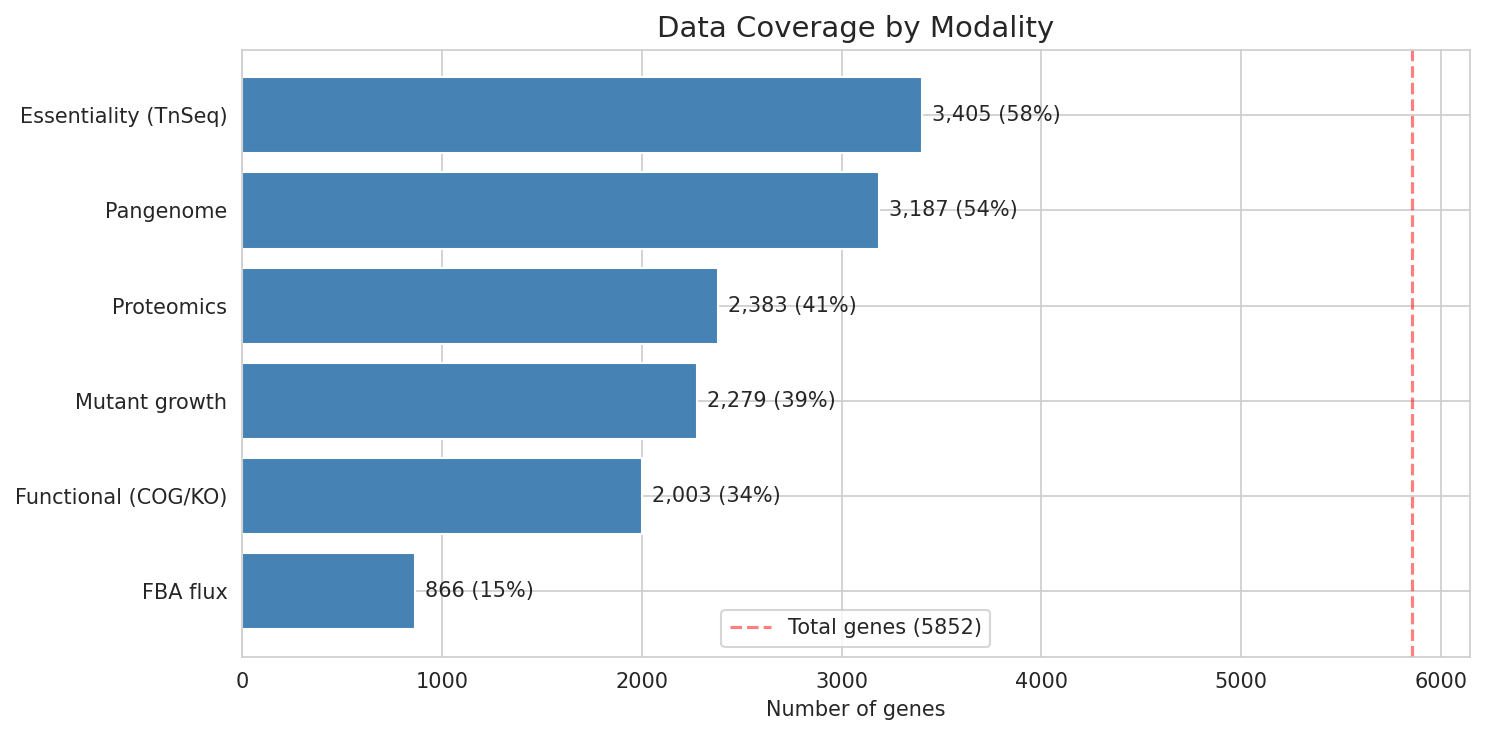

In [10]:
# Data availability per modality
modalities = {
    'Essentiality (TnSeq)': gf['essentiality_lb'].notna(),
    'FBA flux': gf['rich_media_class'].notna(),
    'Mutant growth': gf[growth_cols[0]].notna(),
    'Proteomics': gf[prot_cols[0]].notna(),
    'Pangenome': gf['pangenome_is_core'].notna(),
    'Functional (COG/KO)': gf['cog'].notna() | gf['ko'].notna(),
}

# UpSet-style count
print('Data availability per modality:')
for name, mask in modalities.items():
    print(f'  {name:<25} {mask.sum():>5} genes ({mask.sum()/len(gf)*100:.0f}%)')

# How many genes have ALL modalities?
all_mask = pd.concat(modalities.values(), axis=1).all(axis=1)
print(f'\n  All modalities combined  {all_mask.sum():>5} genes ({all_mask.sum()/len(gf)*100:.0f}%)')

# Visualization: bar chart of modality coverage
fig, ax = plt.subplots(figsize=(10, 5))
coverage = pd.Series({name: mask.sum() for name, mask in modalities.items()})
coverage = coverage.sort_values(ascending=True)
bars = ax.barh(coverage.index, coverage.values, color='steelblue')
ax.axvline(x=len(gf), color='red', linestyle='--', alpha=0.5, label=f'Total genes ({len(gf)})')
for bar, val in zip(bars, coverage.values):
    ax.text(val + 50, bar.get_y() + bar.get_height()/2,
            f'{val:,} ({val/len(gf)*100:.0f}%)', va='center', fontsize=10)
ax.set_title('Data Coverage by Modality', fontsize=14)
ax.set_xlabel('Number of genes')
ax.legend()
plt.tight_layout()
plt.savefig('../figures/data_coverage_by_modality.png', dpi=150, bbox_inches='tight')
plt.show()

conn.close()